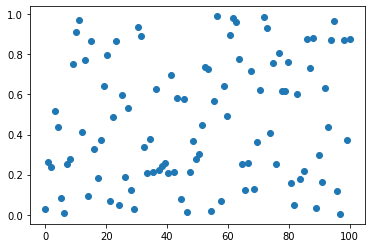

In [ ]:
import pandas as pd
import math
import numpy as np
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
from google.colab import files
import matplotlib.mlab as mlab

N = 100
x = np.linspace(0, N, num=N)
y = np.random.uniform(size=N)
plt.scatter(x, y)

# Finite diference zbiorcze

In [ ]:
pay_off = function(S, K, czy_call = T) if(czy_call) pmax(S - K, 0) else pmax(K - S, 0)

delta = function(v, dS) (v[1] - v[3]) / (2 * dS)
gamma = function(v, dS) (v[1] - 2 * v[2] + v[3])  / dS^2

wycena = function(v, dt, dS, S, r, zmiennosc_roczna){
  d = delta(v, dS)
  g = gamma(v, dS)
  if (length(zmiennosc_roczna) != 1){
    if (g < 0) zmiennosc_roczna = zmiennosc_roczna[1]
    else zmiennosc_roczna = zmiennosc_roczna[2]
  }
  a = zmiennosc_roczna^2 * S^2 / 2
  b = r * S
  c = -r
  return(v[2] + (a * g + b * d + c * v[2]) * dt)
}


##################
#wasciwa czesc
#############



finite_diference_call = function(dS, dt, t = 0.75, K, r, zmiennosc_roczna, bariera, czy_amerykanska = F, wartosc_opcji = T){
  if (is.nan(dt)) {
    dt = dS^2/(zmiennosc_roczna[2]^2 * bariera^2)
    kroki = round(t / dt)
    dt = t / kroki
  }
  
  V = function(v, S) wycena(v = v, dt = dt, dS = dS, S = S, r = r, zmiennosc_roczna = zmiennosc_roczna)
  
  S_v = seq(0, bariera, dS)
  t_v = seq(0, t, dt)
  n_S = length(S_v)
  n_t = length(t_v)
  siatka = matrix(0, n_S, n_t)
  wykonanie = matrix(0, n_S, n_t - 1)
  payoff = pay_off(S = S_v, K = K, czy_call = T)
  payoff[n_S] = 0
  siatka[, n_t] = payoff
  for (j in (n_t - 1):1) {
    for (i in (n_S - 1):2) {
      siatka[i, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i])
      if (sum(siatka[i:(i + 1), j + 1]) == 0) break
    }
    if (czy_amerykanska){
      tmp = siatka[, j] < payoff
      siatka[tmp, j] = payoff[tmp]
      wykonanie[, j] = tmp
    }
  }
  rownames(siatka) = S_v
  colnames(siatka) = t_v
  if(!wartosc_opcji & czy_amerykanska) return(return(list("siatka" = siatka, "wykonanie" = wykonanie)))
  else return(siatka)
}


a = finite_diference_call(dS = 20, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.75, czy_amerykanska = F)
a[,1]

plot_ly(z = ~a) %>% add_surface()



finite_diference_put = function(dS, dt, t = 0.75, K, r, zmiennosc_roczna, bariera, czy_amerykanska = F, wartosc_opcji = T){
  if (is.nan(dt)) {
    dt = dS^2/(zmiennosc_roczna[2]^2 *(bariera * 3)^2)
    kroki = round(t / dt)
    dt = t / kroki
  }
  
  
  V = function(v, S) wycena(v = v, dt = dt, dS = dS, S = S, r = r, zmiennosc_roczna = zmiennosc_roczna)
  
  nr_b = ceiling((3 * K - bariera) / bariera)
  S_v = seq(bariera, bariera * nr_b, dS) #chyba cena wykonania * 3 miaa być
  t_v = seq(0, t, dt)
  n_S = length(S_v)
  n_t = length(t_v)
  siatka = matrix(0, n_S, n_t)
  wykonanie = matrix(0, n_S, n_t - 1)
  payoff = pay_off(S = S_v, K = K, czy_call = F)
  payoff[1] = 0
  siatka[, n_t] = payoff
  for (j in (n_t - 1):1) {
    for (i in (2:(n_S - 1))) {
      siatka[i, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i])
      if (sum(siatka[i:(i+1), j + 1]) == 0) break
    }
    if (czy_amerykanska){
      tmp = siatka[, j] < payoff
      siatka[tmp, j] = payoff[tmp]
      wykonanie[, j] = tmp
    }
  }
  rownames(siatka) = S_v
  colnames(siatka) = t_v
  if(!wartosc_opcji & czy_amerykanska) return(return(list("siatka" = siatka, "wykonanie" = wykonanie)))
  else return(siatka)
}


a = finite_diference_put(dS = 50, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15, 0.25), bariera = 1900, t = 0.75, czy_amerykanska = F)
plot_ly(z = ~a) %>% add_surface()
a[which(row.names(a) == 2300), 1]



################################################################
#stala dywidenda
#######################################
finite_diference_call_divident_const = function(dS, dt = NaN, t = 0.75, K, r, zmiennosc_roczna, bariera, t_dywidenda, dywidenda, czy_amerykanska = F){
  if (is.nan(dt)) { # stabilnosc
    dt = dS^2/(zmiennosc_roczna[2]^2*bariera^2)
    kroki = round(t / dt)
    dt = t / kroki
  }
  t_d = round(t_dywidenda / dt)
  przesunicie = dywidenda /dS # dS jest wielokrotnoscia dywidenty
  
  V = function(v, S) wycena(v = v, dt = dt, dS = dS, S = S, r = r, zmiennosc_roczna = zmiennosc_roczna)
  
  S_v = seq(0, bariera, dS)
  t_v = seq(0, t, dt)
  n_S = length(S_v)
  n_t = length(t_v)
  siatka = matrix(0, n_S, n_t)
  wykonanie = matrix(0, n_S, n_t - 1)
  payoff = pay_off(S = S_v, K = K, czy_call = T)
  payoff[n_S] = 0
  siatka[, n_t] = payoff
  for (j in (n_t - 1):1) {
    if (j != t_d){
      for (i in (n_S - 1):2) {
        siatka[i, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i])
      }
    }
    else{
      for (i in (n_S - 1 - przesunicie):2) {
        siatka[i + przesunicie, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i] + dywidenda)
      }
    }
    
    if (czy_amerykanska){
      tmp = siatka[, j] < payoff
      siatka[tmp, j] = payoff[tmp]
      wykonanie[,j] = tmp
    }
  }
  rownames(siatka) = S_v
  colnames(siatka) = t_v
  if (czy_amerykanska) return(list("siatka" = siatka, "wykonanie" = wykonanie))
  else return(siatka)
}


wartosc_opcji = finite_diference_call_divident_const(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.75, t_dywidenda = 0.4,
                                                     dywidenda = 100,czy_amerykanska = F)
indeks = rownames(wartosc_opcji)
czas = colnames(wartosc_opcji)
plot_ly(z = ~wartosc_opcji, y = ~indeks, x = ~czas) %>% add_surface()




finite_diference_put_divident_const = function(dS, dt = NaN, t = 0.75, K, r, zmiennosc_roczna, bariera, t_dywidenda, dywidenda, czy_amerykanska = F){
  if (is.nan(dt)) {
    dt = dS ^ 2 / (zmiennosc_roczna[2] ^ 2 * (K * 3 - bariera) ^ 2)
    kroki = round(t / dt)
    dt = t / kroki
  }
  t_d = round(t_dywidenda / dt)
  przesunicie = dywidenda /dS # dS jest wielokrotnoscia dywidenty
  
  V = function(v, S) wycena(v = v, dt = dt, dS = dS, S = S, r = r, zmiennosc_roczna = zmiennosc_roczna)
  
  S_v = seq(bariera, K * 2, dS) #chyba cena wykonania * 3 miaa być
  t_v = seq(0, t, dt)
  n_S = length(S_v)
  n_t = length(t_v)
  siatka = matrix(0, n_S, n_t)
  wykonanie = matrix(0, n_S, n_t - 1)
  payoff = pay_off(S = S_v, K = K, czy_call = F)
  payoff[1] = 0
  siatka[, n_t] = payoff
  for (j in (n_t - 1):1) {
    if (j != t_d){
      for (i in (n_S - 1):2) {
        siatka[i, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i])
      }
    }
    else{
      for (i in (n_S - 1 - przesunicie):2) {
        siatka[i + przesunicie, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i] + dywidenda)
      }
    }
    if (czy_amerykanska){
      tmp = siatka[, j] < payoff
      siatka[tmp, j] = payoff[tmp]
      wykonanie[,j] = tmp
    }
  }
  rownames(siatka) = S_v
  colnames(siatka) = t_v
  if (czy_amerykanska) return(list("siatka" = siatka, "wykonanie" = wykonanie))
  else return(siatka)
}


wartosc_opcji = finite_diference_put_divident_const(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 1900, t = 0.75, t_dywidenda = 0.4,
                                                    dywidenda = 100,czy_amerykanska = T)
indeks = rownames(wartosc_opcji)
czas = colnames(wartosc_opcji)
plot_ly(z = ~wartosc_opcji, y = ~indeks, x = ~czas) %>% add_surface()



################################################################
#procentowa dywidenda
########################################################
finite_diference_call_divident_percent = function(dS, dt = NaN, t = 0.75, K, r, zmiennosc_roczna, bariera, t_dywidenda, dywidenda, czy_amerykanska = F, wartosc_opcji = T){
  old_dS = dS
  dS = dS * (1 - dywidenda)
  if (bariera %% dS != 0){
    kroki = round(bariera / dS)
    dS = bariera / kroki
  }
  dywidenda = 1 - dS / old_dS
  print(dywidenda)
  
  if (is.nan(dt)) { # stabilnosc
    dt = dS^2/(zmiennosc_roczna[2]^2*bariera^2)
    kroki = round(t / dt)
    dt = t / kroki
  }
  t_d = round(t_dywidenda / dt)
  
  V = function(v, S) wycena(v = v, dt = dt, dS = dS, S = S, r = r, zmiennosc_roczna = zmiennosc_roczna)
  
  S_v = seq(0, bariera, dS)
  t_v = seq(0, t, dt)
  n_S = length(S_v)
  n_t = length(t_v)
  siatka = matrix(0, n_S, n_t)
  wykonanie = matrix(0, n_S, n_t - 1)
  payoff = pay_off(S = S_v, K = K, czy_call = T)
  payoff[n_S] = 0
  siatka[, n_t] = payoff
  for (j in (n_t - 1):1) {
    if (j != t_d){
      for (i in (n_S - 1):2) {
        siatka[i, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i])
      }
    }
    else{
      tmp = finite_diference_call(dS = old_dS, dt = dt, K = K, r = r, zmiennosc_roczna = zmiennosc_roczna, bariera = bariera, t = t, czy_amerykanska = czy_amerykanska, wartosc_opcji = wartosc_opcji)
      if(!wartosc_opcji & czy_amerykanska){
        wykonanie = tmp$wykonanie
        tmp = tmp$siatka
      }
      print(dim(tmp))
      print(j)
      tmp[, j:1] = 0
      przesunicie = n_S - dim(tmp)[1]
      
      for (i in (n_S - 1 - przesunicie):2) {
        tmp[i, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i] / (1 - dywidenda))
      }
      siatka = tmp
      print(c(dS, old_dS))
      dS = old_dS
      S_v = seq(0, bariera, dS)
      n_S = length(S_v)
      payoff = pay_off(S = S_v, K = K, czy_call = T)
      payoff[n_S] = 0
    }
    
    if (czy_amerykanska){
      tmp = siatka[, j] < payoff
      siatka[tmp, j] = payoff[tmp]
      if(!wartosc_opcji & czy_amerykanska) wykonanie[, j] = tmp
    }
  }
  rownames(siatka) = S_v
  colnames(siatka) = t_v
  if(!wartosc_opcji & czy_amerykanska) return(return(list("siatka" = siatka, "wykonanie" = wykonanie)))
  else return(siatka)
}


wartosc_opcji = finite_diference_call_divident_percent(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.75, t_dywidenda = 0.4,
                                                       dywidenda = 0.1,czy_amerykanska = T)
indeks = rownames(wartosc_opcji)
czas = colnames(wartosc_opcji)
plot_ly(z = ~wartosc_opcji, y = ~indeks, x = ~czas) %>% add_surface()




finite_diference_put_divident_percent = function(dS, dt = NaN, t = 0.75, K, r, zmiennosc_roczna, bariera, t_dywidenda, dywidenda, czy_amerykanska = F, wartosc_opcji = T){
  old_dS = dS
  dS = dS * (1 - dywidenda)
  if (bariera %% dS != 0){
    kroki = round(bariera / dS)
    dS = bariera / kroki
  }
  dywidenda = 1 - dS / old_dS
  print(dywidenda)
  
  nr_b = ceiling((3 * K - bariera) / bariera)
  if (is.nan(dt)) {
    dt = dS ^ 2 / (zmiennosc_roczna[2] ^ 2 * (bariera * nr_b) ^ 2)
    kroki = round(t / dt)
    dt = t / kroki
  }
  t_d = round(t_dywidenda / dt)
  
  V = function(v, S) wycena(v = v, dt = dt, dS = dS, S = S, r = r, zmiennosc_roczna = zmiennosc_roczna)
  
  S_v = seq(bariera, bariera * nr_b, dS) #chyba cena wykonania * 3 miaa być
  t_v = seq(0, t, dt)
  n_S = length(S_v)
  n_t = length(t_v)
  siatka = matrix(0, n_S, n_t)
  wykonanie = matrix(0, n_S, n_t - 1)
  payoff = pay_off(S = S_v, K = K, czy_call = F)
  payoff[1] = 0
  siatka[, n_t] = payoff
  for (j in (n_t - 1):1) {
    if (j != t_d){
      for (i in (n_S - 1):2) {
        siatka[i, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i])
      }
    }
    else{
      tmp = finite_diference_put(dS = old_dS, dt = dt, K = K, r = r, zmiennosc_roczna = zmiennosc_roczna, bariera = bariera, t = t, czy_amerykanska = czy_amerykanska, wartosc_opcji = wartosc_opcji)
      if(!wartosc_opcji & czy_amerykanska){
        wykonanie = tmp$wykonanie
        tmp = tmp$siatka
        print("kupa")
      }
      tmp[, j:1] = 0
      przesunicie = n_S - dim(tmp)[1]
      for (i in (n_S - 1 - przesunicie * (1 + 1/nr_b)):2) {
        tmp[i + przesunicie/nr_b, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i] / (1 - dywidenda))
      }
      siatka = tmp
      dS = old_dS
      S_v = seq(bariera, bariera * nr_b, dS)
      n_S = length(S_v)
      payoff = pay_off(S = S_v, K = K, czy_call = F)
      payoff[1] = 0
    }
    if (czy_amerykanska){
      tmp = siatka[, j] < payoff
      siatka[tmp, j] = payoff[tmp]
      if(!wartosc_opcji & czy_amerykanska) wykonanie[, j] = tmp
    }
  }
  rownames(siatka) = S_v
  colnames(siatka) = t_v
  if(!wartosc_opcji & czy_amerykanska) return(return(list("siatka" = siatka, "wykonanie" = wykonanie)))
  else return(siatka)
}


wartosc_opcji = finite_diference_put_divident_percent(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 1900, t = 0.75, t_dywidenda = 0.4,
                                                      dywidenda = 0.1,czy_amerykanska = T)
indeks = rownames(wartosc_opcji)
czas = colnames(wartosc_opcji)
plot_ly(z = ~wartosc_opcji, y = ~indeks, x = ~czas) %>% add_surface()

Parę wykresów

In [ ]:
##############################################
#wykresy
##################


#Dywidenda call EU
wartosc_opcji = finite_diference_call_divident_percent(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.75, t_dywidenda = 0.4,
                                                     dywidenda = 0.1,czy_amerykanska = F)

wartosc_opcji = wartosc_opcji[strtoi(rownames(wartosc_opcji)) > 1400,]
indeks = rownames(wartosc_opcji)
czas = colnames(wartosc_opcji)
plot_ly(z = ~wartosc_opcji, y = ~indeks, x = ~czas) %>% add_surface()
#htmlwidgets::saveWidget(as_widget(p), "index.html")


#Dywidenda call A
wartosc_opcji = finite_diference_call_divident_const(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.75, t_dywidenda = 0.4,
                                                     dywidenda = 200,czy_amerykanska = T)
wykonanie = wartosc_opcji$wykonanie
wartosc_opcji = wartosc_opcji$siatka
indeks = rownames(wartosc_opcji)
czas = colnames(wartosc_opcji)
plot_ly(z = ~wartosc_opcji, y = ~indeks, x = ~czas) %>% add_surface()
#wykonanie
plot_ly(z = ~wykonanie, y = ~indeks, x = ~czas, type = "heatmap")


#put A
wartosc_opcji = finite_diference_put_divident_const(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 900, t = 0.75, t_dywidenda = 0.4,
                                                    dywidenda = 0,czy_amerykanska = T)
wykonanie = wartosc_opcji$wykonanie
wartosc_opcji = wartosc_opcji$siatka
indeks = rownames(wartosc_opcji)
czas = colnames(wartosc_opcji)
plot_ly(z = ~wartosc_opcji, y = ~indeks, x = ~czas) %>% add_surface()
#wykonanie
plot_ly(z = ~wykonanie, y = ~indeks, x = ~czas, type = "heatmap")



#
library(ggplot2)



### call EU
wartosc_opcji = finite_diference_call_divident_const(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.75, t_dywidenda = 0.4,
                                                     dywidenda = 200,czy_amerykanska = F)
to_plot = data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "0.4", indeks = strtoi(rownames(wartosc_opcji)))

wartosc_opcji = finite_diference_call_divident_const(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.75, t_dywidenda = 0.1,
                                                     dywidenda = 200,czy_amerykanska = F)
to_plot = rbind(to_plot, data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "0.1", indeks = strtoi(rownames(wartosc_opcji))))

wartosc_opcji = finite_diference_call_divident_const(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.75, t_dywidenda = 0.6,
                                                     dywidenda = 200,czy_amerykanska = F)
to_plot = rbind(to_plot, data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "0.6", indeks = strtoi(rownames(wartosc_opcji))))

wartosc_opcji = finite_diference_call(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.75, czy_amerykanska = F)
to_plot = rbind(to_plot, data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "brak", indeks = strtoi(rownames(wartosc_opcji))))

ggplot(data=to_plot) + geom_line(aes(x=indeks, y=wartosc_opcji, colour = moment_dywidendy))


###########call EU procent
wartosc_opcji = finite_diference_call_divident_percent(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.75, t_dywidenda = 0.4,
                                                     dywidenda = 0.1,czy_amerykanska = F)
to_plot = data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "0.4", indeks = strtoi(rownames(wartosc_opcji)))

wartosc_opcji = finite_diference_call_divident_percent(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.75, t_dywidenda = 0.1,
                                                     dywidenda = 0.1,czy_amerykanska = F)
to_plot = rbind(to_plot, data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "0.1", indeks = strtoi(rownames(wartosc_opcji))))

wartosc_opcji = finite_diference_call_divident_percent(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.75, t_dywidenda = 0.6,
                                                     dywidenda = 0.1,czy_amerykanska = F)
to_plot = rbind(to_plot, data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "0.6", indeks = strtoi(rownames(wartosc_opcji))))

wartosc_opcji = finite_diference_call(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.75, czy_amerykanska = F)
to_plot = rbind(to_plot, data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "brak", indeks = strtoi(rownames(wartosc_opcji))))

ggplot(data=to_plot[to_plot$indeks>750,]) + geom_line(aes(x=indeks, y=wartosc_opcji, colour = moment_dywidendy))


#####call A procent
wartosc_opcji = finite_diference_call_divident_percent(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.75, t_dywidenda = 0.4,
                                                       dywidenda = 0.1,czy_amerykanska = T)
to_plot = data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "0.4", indeks = strtoi(rownames(wartosc_opcji)))

wartosc_opcji = finite_diference_call_divident_percent(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.75, t_dywidenda = 0.1,
                                                       dywidenda = 0.1,czy_amerykanska = T)
to_plot = rbind(to_plot, data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "0.1", indeks = strtoi(rownames(wartosc_opcji))))

wartosc_opcji = finite_diference_call_divident_percent(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.75, t_dywidenda = 0.6,
                                                       dywidenda = 0.1,czy_amerykanska = T)
to_plot = rbind(to_plot, data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "0.6", indeks = strtoi(rownames(wartosc_opcji))))

wartosc_opcji = finite_diference_call(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.75, czy_amerykanska = T)
to_plot = rbind(to_plot, data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "brak", indeks = strtoi(rownames(wartosc_opcji))))

ggplot(data=to_plot[to_plot$indeks>750,]) + geom_line(aes(x=indeks, y=wartosc_opcji, colour = moment_dywidendy))




###########put EU procent
wartosc_opcji = finite_diference_put_divident_percent(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 1900, t = 0.75, t_dywidenda = 0.4,
                                                       dywidenda = 0.1,czy_amerykanska = F)
to_plot = data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "0.4", indeks = strtoi(rownames(wartosc_opcji)))

wartosc_opcji = finite_diference_put_divident_percent(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 1900, t = 0.75, t_dywidenda = 0.1,
                                                       dywidenda = 0.1,czy_amerykanska = F)
to_plot = rbind(to_plot, data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "0.1", indeks = strtoi(rownames(wartosc_opcji))))

wartosc_opcji = finite_diference_put_divident_percent(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 1900, t = 0.75, t_dywidenda = 0.6,
                                                       dywidenda = 0.1,czy_amerykanska = F)
to_plot = rbind(to_plot, data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "0.6", indeks = strtoi(rownames(wartosc_opcji))))

wartosc_opcji = finite_diference_put(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 1900, t = 0.75, czy_amerykanska = F)
to_plot = rbind(to_plot, data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "brak", indeks = strtoi(rownames(wartosc_opcji))))

ggplot(data=to_plot[to_plot$indeks<4000,]) + geom_line(aes(x=indeks, y=wartosc_opcji, colour = moment_dywidendy))


#####put A procent
wartosc_opcji = finite_diference_put_divident_percent(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 1900, t = 0.75, t_dywidenda = 0.4,
                                                       dywidenda = 0.1,czy_amerykanska = T)
to_plot = data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "0.4", indeks = strtoi(rownames(wartosc_opcji)))

wartosc_opcji = finite_diference_put_divident_percent(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 1900, t = 0.75, t_dywidenda = 0.1,
                                                       dywidenda = 0.1,czy_amerykanska = T)
to_plot = rbind(to_plot, data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "0.1", indeks = strtoi(rownames(wartosc_opcji))))

wartosc_opcji = finite_diference_put_divident_percent(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 1900, t = 0.75, t_dywidenda = 0.6,
                                                       dywidenda = 0.1,czy_amerykanska = T)
to_plot = rbind(to_plot, data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "0.6", indeks = strtoi(rownames(wartosc_opcji))))

wartosc_opcji = finite_diference_put(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 1900, t = 0.75, czy_amerykanska = T)
to_plot = rbind(to_plot, data.frame(wartosc_opcji = wartosc_opcji[,1], moment_dywidendy = "brak", indeks = strtoi(rownames(wartosc_opcji))))

ggplot(data=to_plot[to_plot$indeks<4000,]) + geom_line(aes(x=indeks, y=wartosc_opcji, colour = moment_dywidendy))

In [ ]:
# jawny wzór na cenę europejskiej opcji barierowej (call up-and-out oraz put down-and-out)
cena_europejskiej_opcji_barierowej<-function(So,K,H,sig,r,t,call=T){
  d1=(log(So/K)+(r+sig^2/2)*t)/(sig*sqrt(t))
  d2=d1-sig*sqrt(t)
  lam=(r+sig^2/2)/(sig^2)
  y=log(H^2/(So*K))/(sig*sqrt(t))+lam*sig*sqrt(t)
  c=So*pnorm(d1)-K*exp(-r*t)*pnorm(d2)
  p=-So*pnorm(-d1)+K*exp(-r*t)*pnorm(-d2)
  x1=log(So/H)/(sig*sqrt(t))+lam*sig*sqrt(t)
  y1=log(H/So)/(sig*sqrt(t))+lam*sig*sqrt(t)
  c_ui=So*pnorm(x1)-K*exp(-r*t)*pnorm(x1-sig*sqrt(t))-So*(H/So)^(2*lam)*(pnorm(-y)-pnorm(-y1))+K*exp(-r*t)*(H/So)^(2*lam-2)*(pnorm(-y+sig*sqrt(t))-pnorm(-y1+sig*sqrt(t)))
  p_di=-So*pnorm(-x1)+K*exp(-r*t)*pnorm(-x1+sig*sqrt(t))+So*(H/So)^(2*lam)*(pnorm(y)-pnorm(y1))-K*exp(-r*t)*(H/So)^(2*lam-2)*(pnorm(y-sig*sqrt(t))-pnorm(y1-sig*sqrt(t)))
  if (call) return(c-c_ui)
  else return(p-p_di)
}

cena_europejskiej_opcji_barierowej(So=2175,K=2150,H=2400,r=0.015,sig=0.2,t=0.83)
cena_europejskiej_opcji_barierowej(call=F,So=2175,K=2150,H=1900,r=0.015,sig=0.2,t=0.83)

Podział na call i put (EU i Amerykanskie razem)

In [ ]:
finite_diference_call = function(dS, dt, t = 0.83, K, r, zmiennosc_roczna, bariera, czy_amerykanska = F){
  if (is.nan(dt)) {
    dt = dS^2/(zmiennosc_roczna[2]^2*bariera^2)
    kroki = round(t / dt)
    dt = t / kroki
  }
  
  V = function(v, S) wycena(v = v, dt = dt, dS = dS, S = S, r = r, zmiennosc_roczna = zmiennosc_roczna)
  
  S_v = seq(0, bariera, dS)
  t_v = seq(0, t, dt)
  n_S = length(S_v)
  n_t = length(t_v)
  siatka = matrix(0, n_S, n_t)
  payoff = pay_off(S = S_v, K = K, czy_call = T)
  payoff[n_S] = 0
  siatka[, n_t] = payoff
  for (j in (n_t - 1):1) {
    for (i in (n_S - 1):2) {
      siatka[i, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i])
      if (sum(siatka[i:(i + 1), j + 1]) == 0) break
    }
    if (czy_amerykanska){
      tmp = siatka[, j] < payoff
      siatka[tmp, j] = payoff[tmp]
    }
  }
  rownames(siatka) = S_v
  colnames(siatka) = t_v
  return(siatka)
}


a = finite_diference_call(dS = 20, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.83, czy_amerykanska = F)
a[,1]

plot_ly(z = ~a) %>% add_surface()



finite_diference_put = function(dS, dt, t = 0.83, K, r, zmiennosc_roczna, bariera, czy_amerykanska = F){
  if (is.nan(dt)) {
    dt = dS^2/(zmiennosc_roczna[2]^2*(bariera*2)^2)
    kroki = round(t / dt)
    dt = t / kroki
  }

  
  V = function(v, S) wycena(v = v, dt = dt, dS = dS, S = S, r = r, zmiennosc_roczna = zmiennosc_roczna)
  
  S_v = seq(bariera, K * 2, dS) #chyba cena wykonania * 3 miaa być
  t_v = seq(0, t, dt)
  n_S = length(S_v)
  n_t = length(t_v)
  siatka = matrix(0, n_S, n_t)
  payoff = pay_off(S = S_v, K = K, czy_call = F)
  payoff[1] = 0
  siatka[, n_t] = payoff
  for (j in (n_t - 1):1) {
    for (i in (2:(n_S - 1))) {
      siatka[i, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i])
      if (sum(siatka[i:(i+1), j + 1]) == 0) break
    }
    if (czy_amerykanska){
      tmp = siatka[, j] < payoff
      siatka[tmp, j] = payoff[tmp]
    }
  }
  rownames(siatka) = S_v
  colnames(siatka) = t_v
  return(siatka)
}


a = finite_diference_put(dS = 50, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15, 0.25), bariera = 1900, t = 0.83, czy_amerykanska = F)
plot_ly(z = ~a) %>% add_surface()
a[which(row.names(a) == 2300), 1]

Stała dywidenda

In [ ]:
library(plotly)

finite_diference_call_divident_const = function(dS, dt = NaN, t = 0.83, K, r, zmiennosc_roczna, bariera, t_dywidenda, dywidenda, czy_amerykanska = F){
  if (is.nan(dt)) { # stabilnosc
    dt = dS^2/(zmiennosc_roczna[2]^2*bariera^2)
    kroki = round(t / dt)
    dt = t / kroki
  }
  t_d = round(t_dywidenda / dt)
  przesunicie = dywidenda /dS # dS jest wielokrotnoscia dywidenty

  V = function(v, S) wycena(v = v, dt = dt, dS = dS, S = S, r = r, zmiennosc_roczna = zmiennosc_roczna)
  
  S_v = seq(0, bariera, dS)
  t_v = seq(0, t, dt)
  n_S = length(S_v)
  n_t = length(t_v)
  siatka = matrix(0, n_S, n_t)
  payoff = pay_off(S = S_v, K = K, czy_call = T)
  payoff[n_S] = 0
  siatka[, n_t] = payoff
  for (j in (n_t - 1):1) {
    if (j != t_d){
      for (i in (n_S - 1):2) {
        siatka[i, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i])
      }
    }
    else{
      for (i in (n_S - 1 - przesunicie):2) {
        siatka[i + przesunicie, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i] + dywidenda)
      }
    }
    
    if (czy_amerykanska){
      tmp = siatka[, j] < payoff
      siatka[tmp, j] = payoff[tmp]
    }
  }
  rownames(siatka) = S_v
  colnames(siatka) = t_v
  return(siatka)
}

wartosc_opcji = finite_diference_call_divident_const(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.83, t_dywidenda = 0.4,
                                         dywidenda = 100,czy_amerykanska = F)
indeks = rownames(wartosc_opcji)
czas = colnames(wartosc_opcji)
plot_ly(z = ~wartosc_opcji, y = ~indeks, x = ~czas) %>% add_surface()




finite_diference_put_divident_const = function(dS, dt = NaN, t = 0.83, K, r, zmiennosc_roczna, bariera, t_dywidenda, dywidenda, czy_amerykanska = F){
  if (is.nan(dt)) {
    dt = dS ^ 2 / (zmiennosc_roczna[2] ^ 2 * (bariera * 2) ^ 2)
    kroki = round(t / dt)
    dt = t / kroki
  }
  t_d = round(t_dywidenda / dt)
  przesunicie = dywidenda /dS # dS jest wielokrotnoscia dywidenty
  
  V = function(v, S) wycena(v = v, dt = dt, dS = dS, S = S, r = r, zmiennosc_roczna = zmiennosc_roczna)
  
  S_v = seq(bariera, K * 2, dS) #chyba cena wykonania * 3 miaa być
  t_v = seq(0, t, dt)
  n_S = length(S_v)
  n_t = length(t_v)
  siatka = matrix(0, n_S, n_t)
  payoff = pay_off(S = S_v, K = K, czy_call = F)
  payoff[1] = 0
  siatka[, n_t] = payoff
  for (j in (n_t - 1):1) {

    if (j != t_d){
      for (i in (n_S - 1):2) {
        siatka[i, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i])
      }
    }
    else{
      for (i in (n_S - 1 - przesunicie):2) {
        siatka[i + przesunicie, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i] + dywidenda)
      }
    }
    if (czy_amerykanska){
      tmp = siatka[, j] < payoff
      siatka[tmp, j] = payoff[tmp]
    }
  }
  rownames(siatka) = S_v
  colnames(siatka) = t_v
  return(siatka)
}

wartosc_opcji = finite_diference_put_divident_const(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 1800, t = 0.83, t_dywidenda = 0.4,
                                                     dywidenda = 100,czy_amerykanska = T)
indeks = rownames(wartosc_opcji)
czas = colnames(wartosc_opcji)
plot_ly(z = ~wartosc_opcji, y = ~indeks, x = ~czas) %>% add_surface()

Put
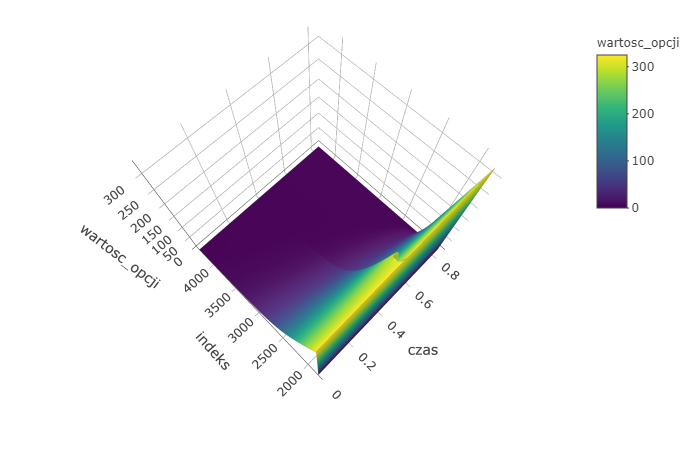

In [ ]:
Zmienna dywidenda

In [ ]:
finite_diference_call_divident_percent = function(dS, dt = NaN, t = 0.83, K, r, zmiennosc_roczna, bariera, t_dywidenda, dywidenda, czy_amerykanska = F){
  old_dS = dS
  dS = dS * (1 - dywidenda)
  if (bariera %% dS != 0){
    kroki = round(bariera / dS)
    dS = bariera / kroki
  }
  dywidenda = 1 - dS / old_dS
  print(dywidenda)
  
  if (is.nan(dt)) { # stabilnosc
    dt = dS^2/(zmiennosc_roczna[2]^2*bariera^2)
    kroki = round(t / dt)
    dt = t / kroki
  }
  t_d = round(t_dywidenda / dt)
  
  V = function(v, S) wycena(v = v, dt = dt, dS = dS, S = S, r = r, zmiennosc_roczna = zmiennosc_roczna)
  
  S_v = seq(0, bariera, dS)
  t_v = seq(0, t, dt)
  n_S = length(S_v)
  n_t = length(t_v)
  siatka = matrix(0, n_S, n_t)
  payoff = pay_off(S = S_v, K = K, czy_call = T)
  payoff[n_S] = 0
  siatka[, n_t] = payoff
  for (j in (n_t - 1):1) {
    if (j != t_d){
      for (i in (n_S - 1):2) {
        siatka[i, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i])
      }
    }
    else{
      tmp = finite_diference_call(dS = old_dS, dt = dt, K = K, r = r, zmiennosc_roczna = zmiennosc_roczna, bariera = bariera, t = t, czy_amerykanska = czy_amerykanska)
      tmp[, j:1] = 0
      przesunicie = n_S - dim(tmp)[1]
      
      for (i in (n_S - 1 - przesunicie):2) {
        tmp[i, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i] / (1 - dywidenda))
      }
      siatka = tmp
      print(c(dS, old_dS))
      dS = old_dS
      S_v = seq(0, bariera, dS)
      n_S = length(S_v)
      payoff = pay_off(S = S_v, K = K, czy_call = T)
      payoff[n_S] = 0
    }
    
    if (czy_amerykanska){
      tmp = siatka[, j] < payoff
      siatka[tmp, j] = payoff[tmp]
    }
  }
  rownames(siatka) = S_v
  colnames(siatka) = t_v
  return(siatka)
}


wartosc_opcji = finite_diference_call_divident_percent(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 2400, t = 0.83, t_dywidenda = 0.4,
                                                     dywidenda = 0.1,czy_amerykanska = T)
indeks = rownames(wartosc_opcji)
czas = colnames(wartosc_opcji)
plot_ly(z = ~wartosc_opcji, y = ~indeks, x = ~czas) %>% add_surface()

In [ ]:
finite_diference_put_divident_percent = function(dS, dt = NaN, t = 0.83, K, r, zmiennosc_roczna, bariera, t_dywidenda, dywidenda, czy_amerykanska = F){
  old_dS = dS
  dS = dS * (1 - dywidenda)
  if (bariera %% dS != 0){
    kroki = round(bariera / dS)
    dS = bariera / kroki
  }
  dywidenda = 1 - dS / old_dS
  print(dywidenda)
  
  if (is.nan(dt)) {
    dt = dS ^ 2 / (zmiennosc_roczna[2] ^ 2 * (bariera * 2) ^ 2)
    kroki = round(t / dt)
    dt = t / kroki
  }
  t_d = round(t_dywidenda / dt)

  V = function(v, S) wycena(v = v, dt = dt, dS = dS, S = S, r = r, zmiennosc_roczna = zmiennosc_roczna)
  
  S_v = seq(bariera, bariera * 2, dS) #chyba cena wykonania * 3 miaa być
  t_v = seq(0, t, dt)
  n_S = length(S_v)
  n_t = length(t_v)
  siatka = matrix(0, n_S, n_t)
  payoff = pay_off(S = S_v, K = K, czy_call = F)
  payoff[1] = 0
  siatka[, n_t] = payoff
  for (j in (n_t - 1):1) {
    if (j != t_d){
      for (i in (n_S - 1):2) {
        siatka[i, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i])
      }
    }
    else{
      tmp = finite_diference_put(dS = old_dS, dt = dt, K = K, r = r, zmiennosc_roczna = zmiennosc_roczna, bariera = bariera, t = t, czy_amerykanska = czy_amerykanska)
      tmp[, j:1] = 0
      przesunicie = n_S - dim(tmp)[1]
      for (i in (n_S - 1 - przesunicie * 1.5):2) {
        tmp[i + przesunicie/2, j] = V(siatka[(i + 1):(i - 1), j + 1], S_v[i] / (1 - dywidenda))
      }
      siatka = tmp
      dS = old_dS
      S_v = seq(bariera, bariera * 2, dS)
      n_S = length(S_v)
      payoff = pay_off(S = S_v, K = K, czy_call = F)
      payoff[1] = 0
    }
    if (czy_amerykanska){
      tmp = siatka[, j] < payoff
      siatka[tmp, j] = payoff[tmp]
    }
  }
  rownames(siatka) = S_v
  colnames(siatka) = t_v
  return(siatka)
}


wartosc_opcji = finite_diference_put_divident_percent(dS = 25, dt = NaN, K = 2150, r = 0.015, zmiennosc_roczna = c(0.15,0.25), bariera = 1800, t = 0.83, t_dywidenda = 0.4,
                                                    dywidenda = 0.1,czy_amerykanska = T)
indeks = rownames(wartosc_opcji)
czas = colnames(wartosc_opcji)
plot_ly(z = ~wartosc_opcji, y = ~indeks, x = ~czas) %>% add_surface()

In [ ]:
# drzewo trójmianowe z barierą
trinomial_barrier_tree<-function(So,H,sig,dt,Tt,call){
  n=floor(Tt/dt+0.5)
  if (call){
    N=floor((log(H)-log(So))/(sig*sqrt(3*dt))+0.5)
    u=exp((log(H)-log(So))/N)
    d=1/u
  } else {
    N=floor((log(H)-log(So))/(-sig*sqrt(3*dt))+0.5)
    d=exp((log(H)-log(So))/N)
    u=1/d
  } 
  tree=list()
  tmp=c(So)
  tree[[1]]=tmp
  for (i in 1:n){
    tmp=c(u*tmp[1],tmp,d*tmp[length(tmp)])
    tree[[i+1]]=tmp
  }
  tree
}

# wycena opcji barierowej call (europejska i amerykańska) przy użyciu drzewa trójmianowego
up_and_out<-function(So,K,H,sig,dt,Tt,r,eu=T){
  ov=list()
  tree=trinomial_barrier_tree(So,H,sig,dt,Tt,call=T)
  n=floor(Tt/dt+0.5)
  N=floor((log(H)-log(So))/(sig*sqrt(3*dt))+0.5)
  u=exp((log(H)-log(So))/N)
  d=1/u
  pd=-(r-sig^2/2)*dt/(2*log(u))+sig^2*dt/(2*log(u)^2)
  pm=1-sig^2*dt/(log(u)^2)
  pu=(r-sig^2/2)*dt/(2*log(u))+sig^2*dt/(2*log(u)^2)
  ov[[n+1]]=pmax(0,tree[[n+1]]-K)
  ov[[n+1]][1:(n+1-N)]=rep(0,n+1-N)
  for (i in n:1){
    f=ov[[i+1]]
    k=length(f)
    tmp=pd*f[-c(1,2)]+pm*f[-c(1,k)]+pu*f[-c(k-1,k)]
    tmp=tmp*exp(-r*dt)
    if (eu) ov[[i]]=tmp
    else ov[[i]]=pmax(tmp,tree[[i]]-K)
    if (i-N>0) ov[[i]][1:(i-N)]=rep(0,i-N)
  }
  ov
}

up_and_out(So=2175,K=2150,H=2400,r=0.015,sig=0.2,Tt=0.83,dt=0.001,eu=T)[[1]]
up_and_out(So=2175,K=2150,H=2400,r=0.015,sig=0.2,Tt=0.83,dt=0.001,eu=F)[[1]]

# wycena opcji barierowej put (europejska i amerykańska) przy użyciu drzewa trójmianowego
down_and_out<-function(So,K,H,sig,dt,Tt,r,eu=T){
  ov=list()
  tree=trinomial_barrier_tree(So,H,sig,dt,Tt,call=F)
  n=floor(Tt/dt+0.5)
  N=floor((log(H)-log(So))/(-sig*sqrt(3*dt))+0.5)
  d=exp((log(H)-log(So))/N)
  u=1/d
  pd=-(r-sig^2/2)*dt/(2*log(u))+sig^2*dt/(2*log(u)^2)
  pm=1-sig^2*dt/(log(u)^2)
  pu=(r-sig^2/2)*dt/(2*log(u))+sig^2*dt/(2*log(u)^2)
  ov[[n+1]]=pmax(0,K-tree[[n+1]])
  ov[[n+1]][(n+1+N):(2*n+1)]=rep(0,n+1-N)
  for (i in n:1){
    f=ov[[i+1]]
    k=length(f)
    tmp=pd*f[-c(1,2)]+pm*f[-c(1,k)]+pu*f[-c(k-1,k)]
    tmp=tmp*exp(-r*dt)
    if (eu) ov[[i]]=tmp
    else ov[[i]]=pmax(tmp,K-tree[[i]])
    if (i-N>0) ov[[i]][(i+N):(2*i-1)]=rep(0,i-N)
  }
  ov
}

down_and_out(So=2175,K=2150,H=1900,r=0.015,sig=0.2,Tt=0.83,dt=0.001,eu=T)[[1]]
down_and_out(So=2175,K=2150,H=1900,r=0.015,sig=0.2,Tt=0.83,dt=0.001,eu=F)[[1]]